 # IMA 205 CHALLENGE 2023 : MRI images classification

#### Name : Fatima Baldé

#### Teacher :  Loic Le Folgoc, Pietro Gori

# Summary
* Introduction
* Libraries
* Data exploration
* Feature extraction
* Pre-processing
* Multi-classification
* Test segmentation

# Introduction

The goal of this challenge is to classify MRI images of the heart among 5 classes.
1. Healthy controls
2. Myocardial infarction
3. Dilated cardiomyopathy
4. Hypertrophic cardiomyopathy
5. Abnormal right ventricle


# Libraries

In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from skimage.io import imread
from skimage import feature
from time import time
import matplotlib.pyplot as plt
import nibabel as nib
from scipy import ndimage

from scipy.spatial.distance import cdist
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV, KFold, cross_validate,cross_val_score
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler,  MinMaxScaler

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import itertools

# Data exploration

The data is available on kaggle [https://www.kaggle.com/competitions/ima205-challenge-2023]
To import them in the notebook you'll need to define the right working directory. \
We put all the paths of the train and test images in arrays \
end_sys is the array of the end systole path images \
end_dia is the array of the end diastole path images \
seg_sys is the array of the end systole path images \
seg_dia is the array of the end diastole path images \
We do the same for the test images

In [ ]:
Working_directory="./"
train_directory = Working_directory + 'Train'
test_directory = Working_directory + 'Test'


# Getting arrays for the cell’s images, the cytoplasm segmentation and the nucleus segmentation respectively
import glob
end_sys = sorted(glob.glob(train_directory + '/*/*ES.nii'))
end_dia = sorted(glob.glob(train_directory + '/*/*ED.nii'))
seg_sys = sorted(glob.glob(train_directory + '/*/*ES_seg.nii'))
seg_dia = sorted(glob.glob(train_directory + '/*/*ED_seg.nii'))

end_sys_test = sorted(glob.glob(test_directory + '/*/*ES.nii'))
end_dia_test = sorted(glob.glob(test_directory + '/*/*ED.nii'))
seg_sys_test = sorted(glob.glob(test_directory + '/*/*ES_seg.nii'))
seg_dia_test = sorted(glob.glob(test_directory + '/*/*ED_seg.nii'))

print(0)

0


Let's check some images in the train set \
Images are in 3D so we'll look at some slices of the image  

Text(0.5, 1.0, 'Image seg')

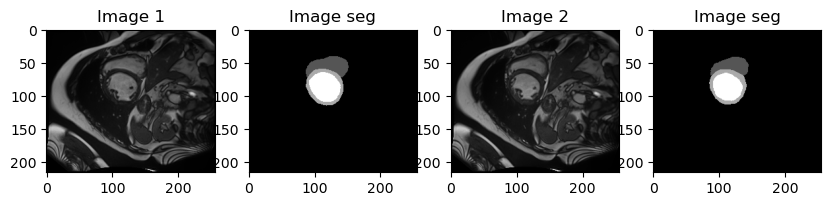

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(10, 5))
img_ed = nib.load(train_directory+'/011/011_ED.nii')
img_ed_data=img_ed.dataobj
img_eds = nib.load(train_directory+'/011/011_ED_seg.nii')
img_eds_data=img_eds.dataobj
img_es = nib.load(train_directory+'/011/011_ES.nii')
img_es_data=img_es.dataobj
img_ess = nib.load(train_directory+'/011/011_ES_seg.nii')
img_ess_data=img_ess.dataobj

axs[0].imshow(img_ed_data[:,:,3], cmap='gray')
axs[0].set_title('Image 1')
axs[1].imshow(img_eds_data[:,:,3], cmap='gray')
axs[1].set_title('Image seg')
axs[2].imshow(img_es_data[:,:,3], cmap='gray')
axs[2].set_title('Image 2')
axs[3].imshow(img_ess_data[:,:,3], cmap='gray')
axs[3].set_title('Image seg')

# Feature extraction

We choose to use these features:
1. Volumes of the anatomical structures :myocardium , left and right ventricules
* To compute the volume of the anatomical structures we have to take into account the volume of our voxels, as the voxels have not the same size for all the images. The volume of a region is defined by the number of voxels in that region multiply by the size of the voxel
2. Ejection fraction of left and rigth ventricules .
* The ejection fraction is equal to $\frac {VED-VES}{VED}$ VES is the end systole volume, and VED is the end dyastole volume
3. Thickness of the myocardium
Computing this feature was a little tricky and I decided to proceed as follow:
- The first step is to recover the label of the myocardium, which has a crown shape. To calculate the thickness of the myocardium, we will try to recover the contours of this crown and take the largest distance from a slice. We will then collect all the distances of all the slices and the thickness will be the average of these distances. We will also return the std of the thickness of all slices.!
 - To recover the contours of the crown, we start by filling the space (using morphology.binary_fill_holes) and we recover the outer contour using canny edge detector(feature.canny). For the inner contour, we take the filled myocardium image and make the difference with the unfilled myocardium. This will leave a part whose outer contour represents the inner contour of the myocardium.
 - The computation of the greatest distance having recovered the two contours is not very obvious. Once we recover the coordinates of these contours, we use the cdist function which for each point will calculate the closest distance to the second contour.
 - In cases where the myocardial contours are not closed, the method fails. In fact the filling (fill_holes) is not done and thus no inner contours are recovered.
These slices are usually the first slices and the last ones. With a quick check by display, I realised that these slices are not numerous and I just decided to do the averaging and the std on the rest of the slices.

4. Weight ang height of the subject which are in the file metadata.csv


  




##### Illustration of thickness computation

Text(0.5, 1.0, 'internal_edges')

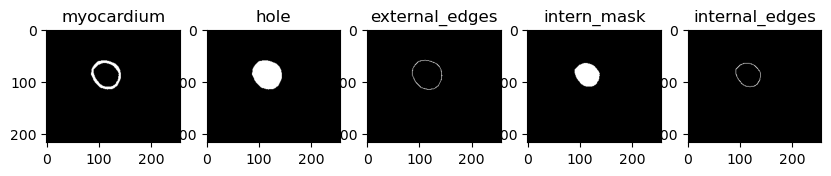

In [ ]:
slice1=img_eds_data[:,:,3]
myocardium=slice1==2
hole=ndimage.morphology.binary_fill_holes(myocardium)
external_edges=feature.canny(hole)
intern_mask=ndimage.morphology.binary_fill_holes(hole-myocardium.astype(int))
internal_edges=feature.canny(intern_mask)

fig, axs = plt.subplots(1, 5, figsize=(10, 5))
axs[0].imshow(myocardium, cmap='gray')
axs[0].set_title('myocardium')
axs[1].imshow(hole, cmap='gray')
axs[1].set_title('hole')
axs[2].imshow(external_edges, cmap='gray')
axs[2].set_title('external_edges')
axs[3].imshow(intern_mask, cmap='gray')
axs[3].set_title('intern_mask')
axs[4].imshow(internal_edges, cmap='gray')
axs[4].set_title('internal_edges')


##### Failure cases

Text(0.5, 1.0, 'internal_edges')

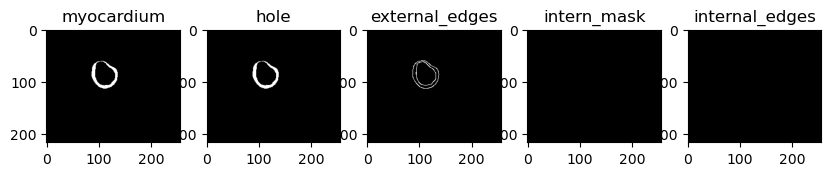

In [ ]:
slice1=img_eds_data[:,:,0]
myocardium=slice1==2
hole=ndimage.morphology.binary_fill_holes(myocardium)
external_edges=feature.canny(hole)
intern_mask=ndimage.morphology.binary_fill_holes(hole-myocardium.astype(int))
internal_edges=feature.canny(intern_mask)

fig, axs = plt.subplots(1, 5, figsize=(10, 5))
axs[0].imshow(myocardium, cmap='gray')
axs[0].set_title('myocardium')
axs[1].imshow(hole, cmap='gray')
axs[1].set_title('hole')
axs[2].imshow(external_edges, cmap='gray')
axs[2].set_title('external_edges')
axs[3].imshow(intern_mask, cmap='gray')
axs[3].set_title('intern_mask')
axs[4].imshow(internal_edges, cmap='gray')
axs[4].set_title('internal_edges')



As mentionned earlier cases where the myocardium is not fully closed are not numerous. Hence, it is usually the the first and last slices. I decided not to compute the thickness of those slices an do the averaging with the other slices.
I did keep in mind that this may be a problem, but  the classification did go quite well which confirms my thoughts.

In [ ]:
#labels of the segmented images
# 0 - Background
#1 - Right ventricle cavity
#2 - Myocardium
#3 - Left ventricle cavity

def anatomical_volumes(img_seg,voxel_size):
    """
    Takes as parameters the segmented image
    Return an array containing the volume of each label
    """
    #a voxel is a pixel with volume
    #the volume of each area is the number of voxel in that area multiply by the voxels size.
    #Images don't have the same voxel size.


    unique_values, counts = np.unique(img_seg, return_counts=True)
    return counts[1:]*np.prod(voxel_size)


def ejection_fraction(img_seg_ed,img_seg_es,voxel_ed,voxel_es):
    """
    Takes the two segmented images of the End diastole and the end systole

    Return the ejection fractions of the left and right ventricule in an array,[right_ej,left_ej]
    """
    #the ejection fraction is define as (the diastole volume minus the systole volume)
    #divided by the diastole volume

    di_volumes=anatomical_volumes(img_seg_ed,voxel_ed)
    sy_volumes=anatomical_volumes(img_seg_es,voxel_es)
    eject_volumes=np.zeros((2))
    ej=(di_volumes-sy_volumes)/di_volumes
    eject_volumes[0]=ej[0]
    eject_volumes[1]=ej[2]
    return eject_volumes


def myocardium_thickness(img_seg):
    """
    Takes a segmented image
    Returns the average thickness and the standard deviation of the myocardium slices

    """
    # We compute the thickness for each slice of the 3D image and take the average

    M,N,P=img_seg.shape
    thickness=[]
    for i in range (P):
        slice_=img_seg[:,:,i]
        myocardium=slice_==2
        hole=ndimage.morphology.binary_fill_holes(myocardium)
        external_edges=feature.canny(hole)
        intern_mask=ndimage.morphology.binary_fill_holes(hole-myocardium.astype(int))
        internal_edges=feature.canny(intern_mask)

        abs_ext,ord_ext=np.where(external_edges!=0)
        abs_int,ord_int=np.where(internal_edges!=0)

        if(abs_ext.shape[0]!=0 and abs_int.shape[0]!=0) :
            forme1=np.column_stack((abs_ext,ord_ext))
            forme2=np.column_stack((abs_int,ord_int))
            distance=cdist(forme1, forme2, 'euclidean')
            distances_min = np.min(distance, axis=1)
            avg=np.max(distances_min)
            thickness.append(avg)
    return np.mean(thickness),np.std(thickness)




# we have in total 13 features to compute
def get_features(path_seg_ed, path_seg_es,nb_features,feature_test_set=False):

    """
    Return an array containing 'volume_rigthVent_es' , 'volume_myocard_es' , 'volume_left_ventes'
    'volume_rigthVent_ed' , 'volume_myocard_ed' , 'volume_left_vented'
    'ejec_fraction_rigth_vent', 'ejec_fraction_left_vent'
    , 'mean_thickness_ed','std_thickness_ed', 'mean_thickness_es'
    , 'std_thickness_es','height','weight'

    """

    img_es=nib.load(path_seg_es)
    img_ed=nib.load(path_seg_ed)
    img_ed_data=img_ed.dataobj
    img_es_data=img_es.dataobj
    if(feature_test_set==True):
        img_es_data=restore_LV_segmentation(img_es_data)
        img_ed_data=restore_LV_segmentation(img_ed_data)

    header_es=img_es.header
    voxel_size_es=header_es.get_zooms()

    header_ed=img_ed.header
    voxel_size_ed=header_ed.get_zooms()

    features=np.zeros((nb_features))

    count_ed=anatomical_volumes(img_ed_data,voxel_size_ed)
    count_es=anatomical_volumes(img_es_data,voxel_size_es)

    ejection=ejection_fraction(img_ed_data,img_es_data,voxel_size_ed,voxel_size_es)

    features[0:count_es.shape[0]]=count_es
    features[count_es.shape[0]: count_es.shape[0]+count_ed.shape[0]]=count_ed
    features[count_es.shape[0]+count_ed.shape[0]:count_es.shape[0]+count_ed.shape[0]+2]=ejection
    features[nb_features-4]=myocardium_thickness(img_ed_data)[0]
    features[nb_features-3]=myocardium_thickness(img_ed_data)[1]
    features[nb_features-2]=myocardium_thickness(img_es_data)[0]
    features[nb_features-1]=myocardium_thickness(img_es_data)[1]


    return features



Once I have decided how to calculate these features, I compute them on my train images and concatenate my results in a features table
I compute then the dataframe associated to visualize the datas.

In [ ]:
## array of all features for the train set
nb_features=12
features_train=[]
features_test=[]


for i in range(len(end_sys)):

    features_train.append(get_features(seg_dia[i], seg_sys[i],nb_features))



features_train = np.array(features_train)


df_train = pd.read_csv(  'metaDataTrain.csv') # reading training data

df_copy_train=np.array(df_train)

features_train_copy=np.concatenate((features_train, df_copy_train[:,2:]),axis=1)


In [ ]:
column_names=['volume_rigth_es' , 'volume_myocard_es' , 'volume_left_es',
    'volume_rigth_ed' , 'volume_myocard_ed' , 'volume_left_vent_ed',
    'ejec_fraction_rigth', 'ejec_fraction_left',
    'mean_thickness_ed','std_thickness_ed', 'mean_thickness_es', 'std_thickness_es','height','weight' ]
df_trainset= pd.DataFrame(features_train_copy, columns=column_names)
df_trainset['class']=df_copy_train[:,1]

In [ ]:
display(df_trainset)

,volume_rigth_es,volume_myocard_es,volume_left_es,volume_rigth_ed,volume_myocard_ed,volume_left_vent_ed,ejec_fraction_rigth,ejec_fraction_left,mean_thickness_ed,std_thickness_ed,mean_thickness_es,std_thickness_es,height,weight,class
0,59545.898438,195068.359375,225610.351562,139721.679688,164257.812500,295507.812500,0.573825,0.236533,6.736290,0.856454,8.775486,0.659761,184.0,95.0,2.0
1,28823.089600,192565.155029,188303.375244,94432.067871,160433.578491,265744.400024,0.694774,0.291412,8.096900,0.969644,10.643157,1.422392,160.0,70.0,2.0
2,174584.960938,201074.218750,241088.867188,192333.984375,191845.703125,276708.984375,0.092282,0.128728,7.617005,0.530321,8.684605,0.988753,165.0,77.0,2.0
3,84543.991089,174957.275391,226472.473145,106264.114380,168452.453613,260847.091675,0.204398,0.131781,7.636154,1.299675,9.274940,0.612766,159.0,46.0,2.0
4,74553.222656,232261.962891,224094.726562,170463.867188,201392.578125,290797.119141,0.562645,0.229378,8.320366,1.127612,10.374491,1.571602,165.0,77.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,217681.544952,115055.795774,74905.895834,284093.103704,116967.021618,152260.992193,0.233767,0.508043,6.344220,0.898015,8.338660,1.103060,186.0,76.0,4.0
96,129096.269611,110345.471619,49664.275764,208836.737221,93511.617722,124381.027813,0.381832,0.600709,6.613284,1.736226,9.219668,1.413405,187.0,82.0,4.0
97,161500.000000,102171.875000,41187.500000,164656.250000,93625.000000,93843.750000,0.019169,0.561106,8.716265,1.858843,12.167051,2.290979,167.0,50.0,4.0
98,136638.365765,92234.882841,74058.950872,200365.734255,92585.646441,140401.102558,0.318055,0.472519,5.148325,0.554302,6.414251,0.886540,180.0,80.0,4.0


# Pre-processing

Let's have a quick look of the datas, to look for eventual outliers.

In [ ]:
df_trainset.describe()

,volume_rigth_es,volume_myocard_es,volume_left_es,volume_rigth_ed,volume_myocard_ed,volume_left_vent_ed,ejec_fraction_rigth,ejec_fraction_left,mean_thickness_ed,std_thickness_ed,mean_thickness_es,std_thickness_es,height,weight,class
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,85884.560036,140378.659770,99056.427597,152986.583556,123775.220649,164614.193015,0.467321,0.463846,7.618483,1.381456,10.560592,1.599924,170.840000,74.960000,2.000000
std,52466.855510,54052.701265,78756.957884,55152.813945,48578.661986,74272.019765,0.178873,0.199215,2.661868,0.872038,3.643851,0.975507,9.710683,16.632037,1.421338
min,10319.305420,36950.366306,19364.364624,47365.570068,32645.726917,49267.578125,0.019169,0.104767,4.441548,0.396234,6.308159,0.366928,140.000000,35.000000,0.000000
25%,51590.940392,99330.182914,41768.805398,111767.578125,92222.349758,118056.015015,0.381631,0.279756,6.069293,0.813070,8.155420,0.844805,165.000000,62.750000,1.000000
50%,70083.984375,136312.031803,64111.283175,152006.927490,117755.895452,149010.534256,0.484081,0.536520,7.021612,1.096253,9.829174,1.248790,171.500000,75.000000,2.000000
75%,108201.879344,166990.416746,132576.656342,181683.391291,156850.768766,199784.668901,0.600360,0.622391,8.116897,1.746521,11.489436,2.232596,178.000000,85.000000,3.000000
max,262817.382812,298291.015625,334457.137264,295117.187500,259052.658081,374376.417091,0.859419,0.818679,20.159514,4.297555,25.573285,4.491994,192.000000,123.000000,4.000000


I mapped the correlation matrix to see if it would be necessary to remove some features
Some features are highly correlated including features related to myocardial thickness.
However, for the myocardial thickness features, I found that leaving only the mean or standard deviation introduced some bias and my results were better by keeping them all even though they were highly correlated.
Since my features are not numerous, it would also be better to keep them all

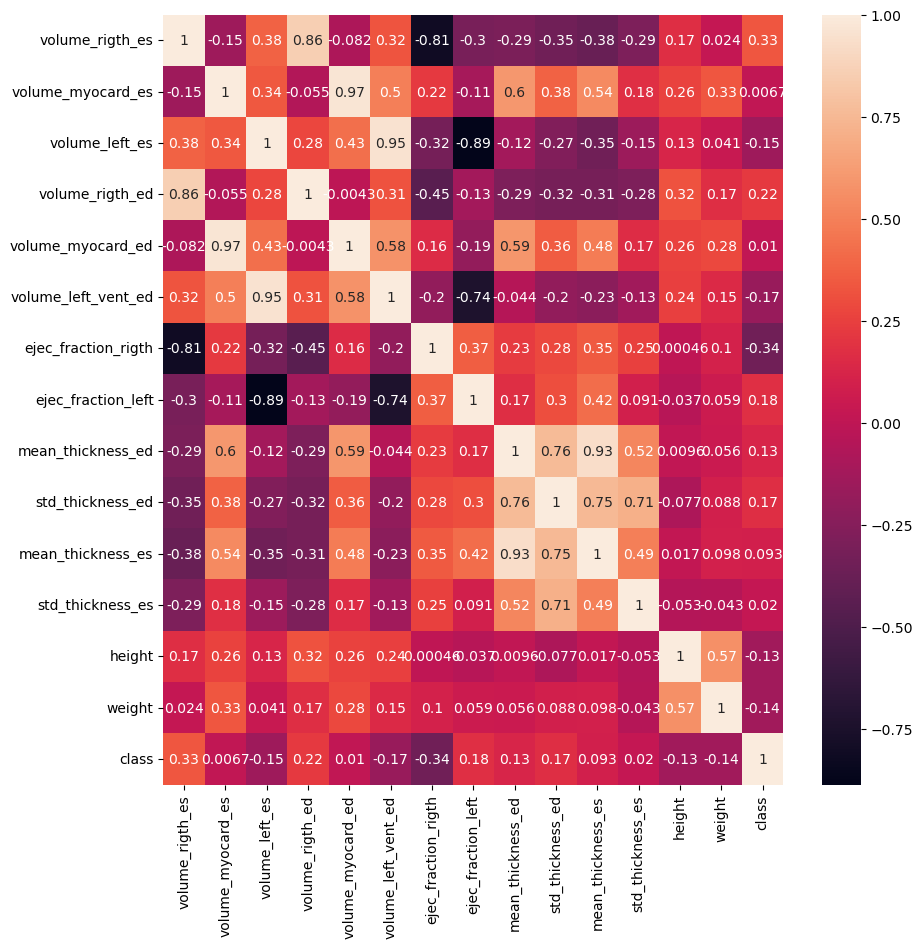

In [ ]:
#correlation matrix
df_test=df_trainset.copy()


col_to_encode=df_trainset.select_dtypes(include='object')
for col in col_to_encode:
    le = LabelEncoder()
    le.fit(df_test[col])
    df_test[col] =  pd.Series(le.transform(df_test[col]))

cor = df_test.corr()
# plotting correlations on a heatmap

# figure size
plt.figure(figsize=(10,10))

# heatmap
sns.heatmap(cor, annot=True)
plt.show()

The first thing to check is the balance of my labels. In fact if there are classes that are few in number, the classification algorithms may have trouble with these classes. In our case the classes are well balanced

In [ ]:
df_test.value_counts('class')

class
0.0    20
1.0    20
2.0    20
3.0    20
4.0    20
dtype: int64

We can separate our datas into train and test sent by using train_test_split

In [ ]:
X=features_train_copy
y=df_copy_train[:,1].reshape(-1,1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)


Another check of the balance of my labels

Text(0, 0.5, 'Proportion')

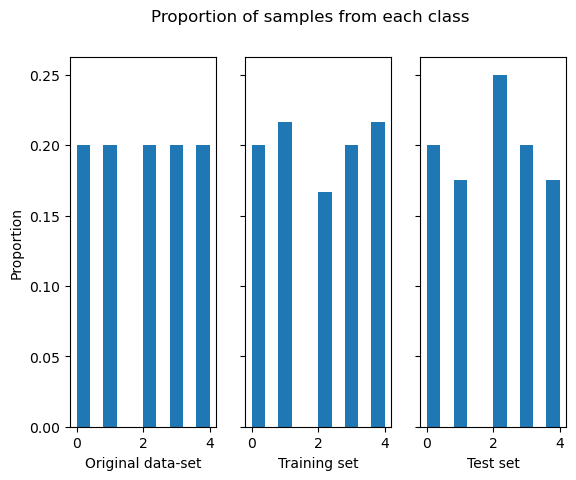

In [ ]:
fig, axs = plt.subplots(1, 3, sharey=True)
fig.suptitle('Proportion of samples from each class')
axs[0].hist(y,weights=np.ones_like(y)/len(y))
axs[0].set_xlabel('Original data-set')
axs[1].hist(y_train,weights=np.ones_like(y_train)/len(y_train))
axs[1].set_xlabel('Training set')
axs[2].hist(y_test,weights=np.ones_like(y_test)/len(y_test))
axs[2].set_xlabel('Test set')

axs[0].set_ylabel('Proportion')

In [ ]:
np.unique(y_test, return_counts=True)

(array([0., 1., 2., 3., 4.]), array([ 8,  7, 10,  8,  7]))

Another pre-processing would be the normalisation or standardisation of our data. If we look at the values of our data, we realise that they are very large, so this treatment is necessary

In [ ]:
#normalization
normalizer = MinMaxScaler()
normalizer.fit(X_train)
X_train_norm=normalizer.transform(X_train)
X_test_norm=normalizer.transform(X_test)

# Scale data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scale=scaler.transform(X_train)
X_test_scale=scaler.transform(X_test)

## Multi-class Classification

I used this fonction taken from one lab made in class. It helps me to visualize where the models fails.

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

##### First Model
The first thing to check is the separability of the data.
We can check if the LDA, which is a classification algorithm with linear boundaries, has good results.
If the LDA has very good results, this means that our data are linearly separable.
The choice was made on LDA because it is a rather fast algorithm but we should take into account that LDA assumes that our data follow a Gaussian distribution.

In [ ]:
clf_LDA = LinearDiscriminantAnalysis()
cv_results = cross_validate(clf_LDA, X, y.ravel(), cv=5,scoring='accuracy',return_train_score=True)
print("Score on train data: ",cv_results['train_score'])
print("Validation Score: ",cv_results['test_score'])
clf_LDA.fit(X_train_norm,y_train.ravel())
y_pred=clf_LDA.predict(X_test_norm)

Score on train data:  [0.975  0.975  0.9625 0.975  0.95  ]
Validation Score:  [0.9  0.9  0.85 0.85 0.95]


Normalized confusion matrix
[[0.875      0.         0.         0.         0.125     ]
 [0.         0.85714286 0.14285714 0.         0.        ]
 [0.         0.         1.         0.         0.        ]
 [0.125      0.         0.         0.875      0.        ]
 [0.14285714 0.         0.         0.         0.85714286]]


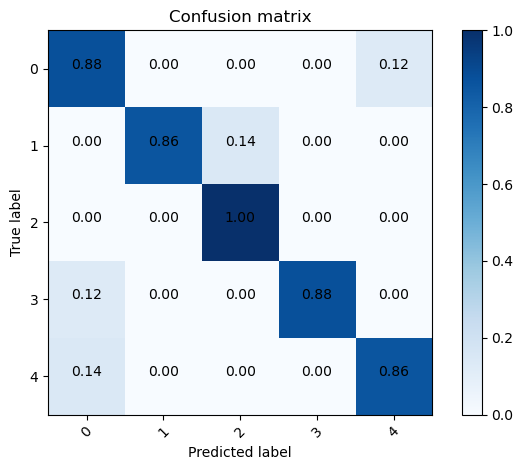

In [ ]:
class_names=['0','1','2','3','4']
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True)
plt.show()

The results are quite good. But we can try to do better. I think that the assumption about the distribution of data is the cause of the failure of the classification

##### Second Model
We will now try SVM algorithms.
Since we know that the classes have a certain separability, we can start with the linear SVM
To avoid introducing bias, we will use a GridSearchCV which will allow us to have the best C parameter giving the best score

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
# Looking for the best hyperparameter C
Lsvm =LinearSVC(max_iter=10000)
p_grid_lsvm = {'C': [1e-3,1e-2,1e-1,1,2,3,4,5,6,7,8,9,1e1]}
grid_lsvm = GridSearchCV(estimator=Lsvm,param_grid=p_grid_lsvm, scoring="accuracy", cv=5)
grid_lsvm.fit(X_train_norm,y_train.ravel())


print("Best training Score: {}".format(grid_lsvm.best_score_))
print("Best training params: {}".format(grid_lsvm.best_params_))
print("Score on the validation set:{}".format(grid_lsvm.score(X_test_norm,y_test)))
y_pred = grid_lsvm.predict(X_test_norm)




Best training Score: 0.8666666666666668
Best training params: {'C': 0.1}
Score on the validation set:0.825


Normalized confusion matrix
[[0.625      0.         0.         0.125      0.25      ]
 [0.42857143 0.42857143 0.14285714 0.         0.        ]
 [0.         0.         1.         0.         0.        ]
 [0.         0.         0.         1.         0.        ]
 [0.         0.         0.         0.         1.        ]]


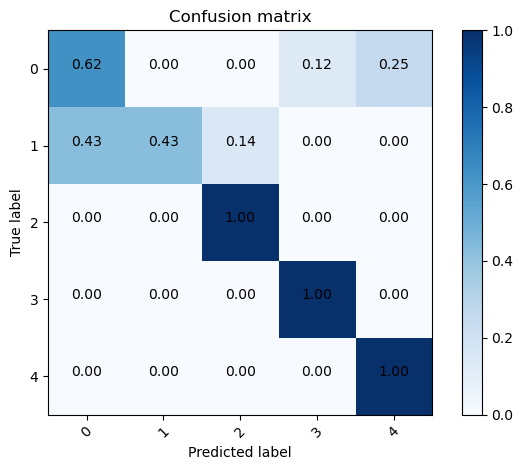

In [ ]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True)
plt.show()


The linear SVM certainly produces better results than the LDA, which confirms that the assumption about the distribution of the data is not true.
I think that the assumption about the separability of the data is also false.

###### Third Model
We can then use the nonlinear SVM which will determine nonlinear boundaries and we can then improve our results.
We also used GridSearchCV to determine the better C and gamma parameters to use

In [ ]:
# Fitting Non-linear SVM
print("Fitting Non-linear SVM to the training set")
NLsvm =  SVC(kernel='rbf')
p_grid_nlsvm = {'C': [1e-3,1e-2,1e-1,1,2,3,4,5,6,7,8,9,1e1],
              'gamma': [0.0001, 0.0005, 0.001,0.002, 0.005, 0.01, 0.1,1]}
grid_nlsvm = GridSearchCV(estimator=NLsvm,param_grid=p_grid_nlsvm, scoring="accuracy", cv=5)
grid_nlsvm.fit(X_train_norm,y_train.ravel())


print("Best training Score: {}".format(grid_nlsvm.best_score_))
print("Best training params: {}".format(grid_nlsvm.best_params_))
print("Score on the validation set:{}".format(grid_nlsvm.score(X_test_norm,y_test)))
y_pred = grid_nlsvm.predict(X_test_norm)

Fitting Non-linear SVM to the training set
Best training Score: 0.9
Best training params: {'C': 4, 'gamma': 0.1}
Score on the validation set:0.925


Normalized confusion matrix
[[1.         0.         0.         0.         0.        ]
 [0.28571429 0.71428571 0.         0.         0.        ]
 [0.         0.         1.         0.         0.        ]
 [0.         0.         0.         1.         0.        ]
 [0.14285714 0.         0.         0.         0.85714286]]


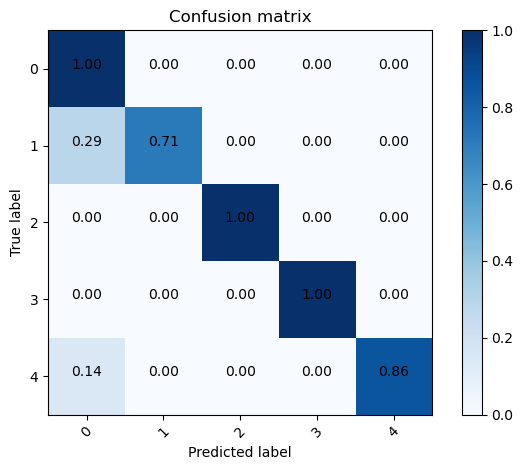

In [ ]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True)
plt.show()

Now that we have found the best SVM for our model, we can try to improve it.
One way to do this would be to try to reduce the dimensionality by using a PCA.
To do this, we will use a pipeline that will allow us to apply the model and the PCA at the same time. Then we will proceed as before using a gridsearchcv to get the optimal parameters

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
NLsvm1 = make_pipeline( PCA(n_components=0.8), SVC(kernel='rbf'))

#NLsvm =  SVC(kernel='rbf')
p_grid_nlsvm = {'svc__C': [1e-3,1e-2,1e-1,1,2,3,4,5,6,7,8,9,1e1],
              'svc__gamma': [0.0001, 0.0005, 0.001,0.002, 0.005, 0.01, 0.1,1]}
grid_nlsvm1 = GridSearchCV(estimator=NLsvm1,param_grid=p_grid_nlsvm, scoring="accuracy", cv=5)
grid_nlsvm1.fit(X_train_norm,y_train.ravel())


print("Best training Score: {}".format(grid_nlsvm1.best_score_))
print("Best training params: {}".format(grid_nlsvm1.best_params_))
print("Score on the validation set:{}".format(grid_nlsvm1.score(X_test_norm,y_test)))
y_pred = grid_nlsvm1.predict(X_test_norm)


Best training Score: 0.85
Best training params: {'svc__C': 1, 'svc__gamma': 1}
Score on the validation set:0.95


Normalized confusion matrix
[[1.         0.         0.         0.         0.        ]
 [0.14285714 0.85714286 0.         0.         0.        ]
 [0.         0.         1.         0.         0.        ]
 [0.         0.         0.         1.         0.        ]
 [0.14285714 0.         0.         0.         0.85714286]]


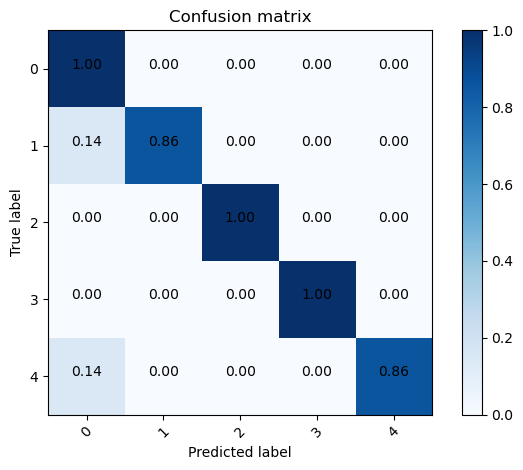

In [ ]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True)
plt.show()

This is better !!

## Test set segmentation

For the segmentation of the test images, it was decided to proceed as follows:
* The myocardium is retrieved and the LV will be the image of the myocardium minus the one with the filled in hole

This is exactly the same procedure as above for the calculation of the myocardial thickness.
And as before the computation may fail but it is just for some rare slices

Text(0.5, 1.0, 'Image seg')

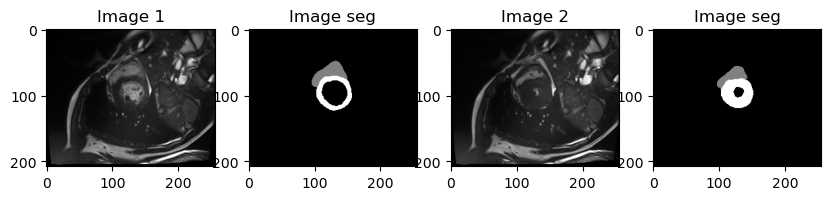

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(10, 5))
img_ed = nib.load(test_directory+'/111/111_ED.nii')
img_ed_data=img_ed.dataobj
img_eds = nib.load(test_directory+'/111/111_ED_seg.nii')
img_eds_data=img_eds.dataobj
img_es = nib.load(test_directory+'/111/111_ES.nii')
img_es_data=img_es.dataobj
img_ess = nib.load(test_directory+'/111/111_ES_seg.nii')
img_ess_data=img_ess.dataobj

axs[0].imshow(img_ed_data[:,:,3], cmap='gray')
axs[0].set_title('Image 1')
axs[1].imshow(img_eds_data[:,:,3], cmap='gray')
axs[1].set_title('Image seg')
axs[2].imshow(img_es_data[:,:,3], cmap='gray')
axs[2].set_title('Image 2')
axs[3].imshow(img_ess_data[:,:,3], cmap='gray')
axs[3].set_title('Image seg')

Text(0.5, 1.0, 'intern_mask')

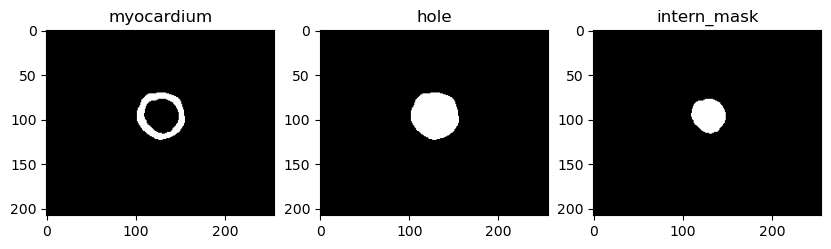

In [ ]:
slice_=img_eds_data[:,:,3]
myocardium=slice_==2
hole=ndimage.morphology.binary_fill_holes(myocardium)
intern_mask=ndimage.morphology.binary_fill_holes(hole-myocardium.astype(int))
abs_int,ord_int=np.where(intern_mask.astype(int)==1)

fig, axs = plt.subplots(1, 3, figsize=(10, 5))
axs[0].imshow(myocardium, cmap='gray')
axs[0].set_title('myocardium')
axs[1].imshow(hole, cmap='gray')
axs[1].set_title('hole')

axs[2].imshow(intern_mask, cmap='gray')
axs[2].set_title('intern_mask')




In [ ]:
def restore_LV_segmentation(img_seg):
    """
    Restore the segmentation of the left ventricule
    Returns a copy of the image with the LV segmented as label 3
    """
    img_copy=np.array(img_seg)
    for i in range(img_seg.shape[2]):
        slice_=img_seg[:,:,i]
        myocardium=slice_==2
        hole=ndimage.morphology.binary_fill_holes(myocardium)
        external_edges=feature.canny(hole)
        intern_mask=ndimage.morphology.binary_fill_holes(hole-myocardium.astype(int))
        internal_edges=feature.canny(intern_mask)
        abs_int,ord_int=np.where(intern_mask.astype(int)==1)
        img_copy[abs_int,ord_int,i]=3

    return img_copy


In [ ]:
## array of all features for the test set
nb_features=12
features_test=[]

for i in range(len(end_sys_test)):
    features_test.append(get_features(seg_dia_test[i], seg_sys_test[i],nb_features,feature_test_set=True))


features_test = np.array(features_test)


df_test = pd.read_csv(  'metaDataTest.csv') # reading test data

df_copy_test=np.array(df_test)

features_test_copy=np.concatenate((features_test, df_copy_test[:,1:]),axis=1)


In [ ]:
df_testset= pd.DataFrame(features_test_copy, columns=column_names)

In [ ]:
df_testset.describe()

,volume_rigth_es,volume_myocard_es,volume_left_es,volume_rigth_ed,volume_myocard_ed,volume_left_vent_ed,ejec_fraction_rigth,ejec_fraction_left,mean_thickness_ed,std_thickness_ed,mean_thickness_es,std_thickness_es,height,weight
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,94172.081921,138770.046155,98600.931821,171548.700624,127370.989783,176576.627838,0.465627,0.507405,7.385081,1.465632,10.423062,1.616180,170.000000,80.700000
std,50673.389009,53650.751578,79585.188018,67851.152075,48987.482687,71063.573644,0.124725,0.222050,2.215871,1.122647,3.534914,0.948506,9.508321,21.978886
min,30988.037109,43250.332975,19925.762894,59761.230469,42457.528181,73914.889841,0.116213,0.075661,4.004521,0.342811,5.645497,0.385382,137.000000,35.000000
25%,63465.768229,105852.690395,39940.313192,125342.971926,96106.339037,125653.929861,0.407831,0.298851,5.848051,0.759173,7.958967,0.961802,165.000000,68.500000
50%,78533.181955,133338.438004,64443.703995,152013.383427,122168.188477,147902.152205,0.462218,0.573724,7.066769,1.145391,9.820591,1.348623,170.000000,80.000000
75%,114880.437189,159655.616305,129785.339355,205199.189200,151382.525549,213676.656232,0.534544,0.686448,8.266096,1.739157,11.672290,2.058950,175.000000,90.750000
max,271630.859375,367542.472588,317480.468750,398738.339853,343541.835106,387748.616760,0.711671,0.844439,16.313671,6.442088,20.731864,5.356288,185.000000,172.000000


In [ ]:
#test=scaler.transform(features_test_copy) normalizer
test=normalizer.transform(features_test_copy)
pred=grid_nlsvm1.predict(test)

In [ ]:
ids = np.arange(101, 151)
df_test = pd.DataFrame({'Id': ids, 'Category': pred.astype(int)})

In [ ]:
df_test

,Id,Category
0,101,2
1,102,4
2,103,0
3,104,3
4,105,4
5,106,1
6,107,0
7,108,0
8,109,4
9,110,4


In [ ]:
df_test.to_csv('SampleSubmission.csv', index=False)

## Conclusion

The less obvious part was the extraction of features including the calculation of myocardial thickness.  At first I only kept the average of the thicknesses and later I included the standard deviation which boosted my classification algorithms.

As far as classification is concerned, I did the test on both standardised and normalised data, but the results were almost similar.
Also I tested with other classification algorithms and the SVM gave better results.

After the classification of my  data test, I had good results on Kaggle(0.94).